In [1]:
# import torch
import requests
import json
from transformers import TFBertForSequenceClassification, AutoTokenizer
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import psutil
import tensorflow as tf
from pynvml import *

c:\Users\HP\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\HP\anaconda3\envs\tf\lib\site-packages\torch\cuda\__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
try:
    df_unseen = pd.read_csv("../test bert.csv")
except FileNotFoundError:
    print("Error: File 'test bert.csv' not found.")
    print("Pastikan file tersebut berada di direktori yang sama dengan script ini.")
    exit()

In [3]:
df_unseen

,Customer Review,Emotion,text_clean
0,"barang sudah sampai tujuan , hanya saja sebelu...",Fear,barang sudah sampai tujuan hanya saja sebelum ...
1,Mohon maaf saya kasih bintang 3 karena ada beb...,Sadness,mohon maaf saya kasih bintang 3 karena ada beb...
2,NaN,Anger,"Saya sudah belanja di Tokped bertahun-tahun, b..."
3,NaN,Love,"enak banget, empuk banget, teksturnya kaya nas..."
4,NaN,Love,"Cepat dikirim ke wilayah Jakarta Selatan, lang..."
...,...,...,...
872,"order minggu sampainya rabu, lambat nya minta ...",Anger,order minggu sampainya rabu lambat nya minta a...
873,Yg satu kuasnya diangkat sudah dalam keadaan p...,Fear,yg satu kuasnya diangkat sudah dalam keadaan p...
874,NaN,Sadness,"kata teman yang berkecimpung di dunia musik, p..."
875,"Nga lengket sama sepatu, lem nya kayak nya lem...",Anger,nga lengket sama sepatu lem nya kayak nya lem ...


In [4]:
df_unseen = df_unseen.dropna(subset=['text_clean'])

In [5]:
df_unseen['text_clean'] = df_unseen['text_clean'].str.lower()

In [6]:
nama_folder_simpan = "../../indobert"
MAX_LENGTH = 256

print("Memuat tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(nama_folder_simpan)

print("Memuat model...")
model = TFBertForSequenceClassification.from_pretrained(
    nama_folder_simpan,
    from_pt=True
)

print("Model siap digunakan!")

Memuat tokenizer...
Memuat model...


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Model siap digunakan!


In [8]:
LABEL_MAP = {
    0: 'Anger',
    1: 'Fear',
    2: 'Happy',
    3: 'Love',
    4: 'Sadness'
}

In [16]:
nvmlInit()
handle = nvmlDeviceGetHandleByIndex(0)

def get_vram_usage_gb():
    info = nvmlDeviceGetMemoryInfo(handle)
    return info.used / (1024 ** 3)

threshold = 0.5

In [17]:
import pandas as pd
print("=== MULAI PREDIKSI MULTICLASS TENSORFLOW ===")

predictions = []
ram_usages = []
vram_usages = []
start_total = time.time()

df_sample = df_unseen.copy()

# Ganti 'title' dengan 'text_clean' dan 'label_score' dengan 'Emotion' (sesuai data Anda)
TEXT_COLUMN = 'text_clean'
LABEL_COLUMN = 'Emotion'

for idx, row in enumerate(df_sample.itertuples(), start=1):
    review_text = getattr(row, TEXT_COLUMN) # Mengambil teks dari kolom 'text_clean'
    
    start_time = time.time()
    
    # 1. Tokenizer (return_tensors='tf' untuk TensorFlow)
    inputs = tokenizer(
        [review_text],
        max_length=MAX_LENGTH,
        padding='max_length',
        truncation=True,
        return_tensors='tf' # <--- DIUBAH ke 'tf'
    )


    ram_before = psutil.virtual_memory().used / (1024 ** 3)
    vram_before = get_vram_usage_gb()

    outputs = model(
        **inputs,
        training=False
    )

    end_time = time.time()

    ram_after = psutil.virtual_memory().used / (1024 ** 3)
    vram_after = get_vram_usage_gb()

    avg_ram = (ram_before + ram_after) / 2
    avg_vram = (vram_before + vram_after) / 2

    ram_usages.append(avg_ram)
    vram_usages.append(avg_vram)

    # --- PERUBAHAN UTAMA UNTUK MULTICLASS TF ---
    # 4. Terapkan Softmax menggunakan tf.nn.softmax
    probabilities = tf.nn.softmax(outputs.logits, axis=-1).numpy().flatten()
    
    # 5. Dapatkan indeks kelas dengan probabilitas tertinggi menggunakan tf.argmax
    pred_class_id = tf.argmax(probabilities).numpy().item() # Gunakan item() untuk mendapatkan int biasa
    
    # 6. Dapatkan probabilitas untuk kelas yang diprediksi tersebut
    prob_score = probabilities[pred_class_id].item() 
    
    # 7. Petakan ID ke label emosi
    pred_label_emotion = LABEL_MAP[pred_class_id]
    # ----------------------------------------
    
    elapsed = end_time - start_time

    predictions.append({
        "teks_ulasan": review_text,
        "prediksi_id": pred_class_id,
        "prediksi_emosi": pred_label_emotion,
        "probabilitas": prob_score,
        "waktu": elapsed,
        "ram": avg_ram,
        "vram": avg_vram,
        "label_asli": getattr(row, LABEL_COLUMN) 
    })

    print(f"[{idx}] Teks: {review_text[:60]}... → Prediksi Emosi: **{pred_label_emotion}** | Prob: {prob_score:.4f} | "
          f"Waktu: {elapsed:.2f}s | RAM: {avg_ram:.2f} GB | VRAM: {avg_vram:.2f} GB")

end_total = time.time()

# --- RINGKASAN AKHIR (Tidak Berubah) ---
total_samples = len(df_sample)
total_time = end_total - start_total
avg_latency = total_time / total_samples
throughput_per_min = (total_samples / total_time) * 60
avg_ram_all = sum(ram_usages) / len(ram_usages)
avg_vram_all = sum(vram_usages) / len(ram_usages)
# ... (lanjutan cetak ringkasan)
print("\n=== RINGKASAN AKHIR ===")
print(f"Total sampel       : {total_samples}")
print(f"Total waktu        : {total_time:.2f} detik")
print(f"Rata-rata latency  : {avg_latency:.2f} detik/sampel")
print(f"Throughput         : {throughput_per_min:.2f} sampel/menit")
print(f"Rata-rata RAM      : {avg_ram_all:.2f} GB")
print(f"Rata-rata VRAM     : {avg_vram_all:.2f} GB")

try:
    # 1. Konversi list of dicts menjadi Pandas DataFrame
    df_predictions = pd.DataFrame(predictions)
    
    # 2. Simpan DataFrame ke file CSV
    output_filename = 'predictions.csv'
    df_predictions.to_csv(output_filename, index=False)
    
    print(f"\n✅ Hasil prediksi berhasil disimpan ke file: **{output_filename}**")

except Exception as e:
    print(f"\n❌ Gagal menyimpan ke CSV: {e}")

=== MULAI PREDIKSI MULTICLASS TENSORFLOW ===
[1] Teks: barang sudah sampai tujuan hanya saja sebelum dikirim mohon ... → Prediksi Emosi: **Happy** | Prob: 0.5414 | Waktu: 0.23s | RAM: 12.93 GB | VRAM: 3.00 GB
[2] Teks: mohon maaf saya kasih bintang 3 karena ada beberapa kendala ... → Prediksi Emosi: **Sadness** | Prob: 0.9705 | Waktu: 0.18s | RAM: 12.93 GB | VRAM: 3.00 GB
[3] Teks: saya sudah belanja di tokped bertahun-tahun, belum pernah ke... → Prediksi Emosi: **Anger** | Prob: 0.9956 | Waktu: 0.19s | RAM: 12.94 GB | VRAM: 3.00 GB
[4] Teks: enak banget, empuk banget, teksturnya kaya nasi, cara buatny... → Prediksi Emosi: **Love** | Prob: 0.9979 | Waktu: 0.23s | RAM: 12.94 GB | VRAM: 3.00 GB
[5] Teks: cepat dikirim ke wilayah jakarta selatan, langsung dipakai d... → Prediksi Emosi: **Love** | Prob: 0.9972 | Waktu: 0.23s | RAM: 12.94 GB | VRAM: 3.00 GB
[6] Teks: mohon diperhatikan barang yang akan dikirim sesuai, pesanan ... → Prediksi Emosi: **Fear** | Prob: 0.9752 | Waktu: 0.20s | RA

In [18]:
nvmlShutdown()

In [19]:
df_predictions = pd.read_csv('predictions.csv')

In [20]:
y_true_emosi = df_predictions['label_asli']
y_pred_emosi = df_predictions['prediksi_emosi']
TARGET_NAMES = ['Anger', 'Fear', 'Happy', 'Love', 'Sadness']

In [21]:
EMOTION_TO_ID = {name: i for i, name in enumerate(TARGET_NAMES)}
y_true_id = y_true_emosi.map(EMOTION_TO_ID).values
y_pred_id = y_pred_emosi.map(EMOTION_TO_ID).values

In [22]:
report = classification_report(y_true_id, y_pred_id, target_names=TARGET_NAMES)
print("\n=== CLASSIFICATION REPORT ===")
print(report)


=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

       Anger       0.80      0.66      0.73       176
        Fear       0.60      0.66      0.63       175
       Happy       0.79      0.86      0.83       175
        Love       0.90      0.82      0.86       176
     Sadness       0.68      0.72      0.70       175

    accuracy                           0.75       877
   macro avg       0.75      0.75      0.75       877
weighted avg       0.75      0.75      0.75       877



In [23]:
precision_avg = precision_score(y_true_id, y_pred_id, average='macro')
recall_avg = recall_score(y_true_id, y_pred_id, average='macro')
f1_avg = f1_score(y_true_id, y_pred_id, average='macro')
accuracy = accuracy_score(y_true_id, y_pred_id)

In [24]:
print(f"\nPrecision avg (Macro) : {precision_avg:.4f}")
print(f"Recall avg (Macro)    : {recall_avg:.4f}")
print(f"F1 avg (Macro)        : {f1_avg:.4f}")
print(f"Akurasi               : {accuracy:.4f}")


Precision avg (Macro) : 0.7535
Recall avg (Macro)    : 0.7457
F1 avg (Macro)        : 0.7472
Akurasi               : 0.7457



Confusion matrix disimpan di 'confusion_matrix_emotion_multiclass.png'


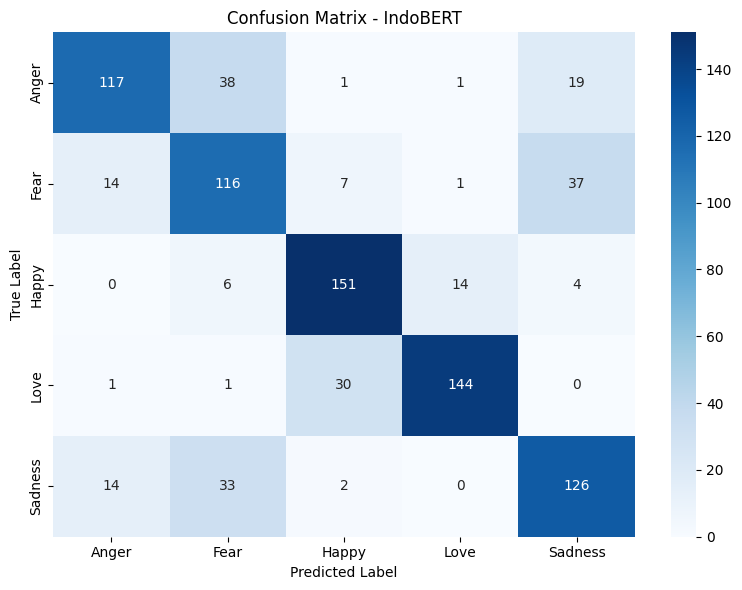

In [27]:
# --- CONFUSION MATRIX MULTICLASS ---
cm = confusion_matrix(y_true_id, y_pred_id)

# Ukuran figure disesuaikan untuk 5 kelas
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            # Gunakan TARGET_NAMES untuk label sumbu (5 label)
            xticklabels=TARGET_NAMES,
            yticklabels=TARGET_NAMES)

plt.title("Confusion Matrix - IndoBERT")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()

# Simpan dan tampilkan
plt.savefig("confusion_matrix_emotion_multiclass.png", dpi=300)
print("\nConfusion matrix disimpan di 'confusion_matrix_emotion_multiclass.png'")
plt.show()

In [26]:
df_predictions

,teks_ulasan,prediksi_id,prediksi_emosi,probabilitas,waktu,ram,vram,label_asli
0,barang sudah sampai tujuan hanya saja sebelum ...,2,Happy,0.541365,0.226177,12.932537,3.002136,Fear
1,mohon maaf saya kasih bintang 3 karena ada beb...,4,Sadness,0.970463,0.178881,12.932379,3.002136,Sadness
2,"saya sudah belanja di tokped bertahun-tahun, b...",0,Anger,0.995611,0.192350,12.936247,3.002136,Anger
3,"enak banget, empuk banget, teksturnya kaya nas...",3,Love,0.997863,0.231845,12.939325,3.002136,Love
4,"cepat dikirim ke wilayah jakarta selatan, lang...",3,Love,0.997241,0.225150,12.936750,3.002136,Love
...,...,...,...,...,...,...,...,...
872,order minggu sampainya rabu lambat nya minta a...,0,Anger,0.908151,0.216734,12.742567,3.002136,Anger
873,yg satu kuasnya diangkat sudah dalam keadaan p...,1,Fear,0.991644,0.172500,12.741859,3.002136,Fear
874,"kata teman yang berkecimpung di dunia musik, p...",4,Sadness,0.908753,0.173176,12.738865,3.002136,Sadness
875,nga lengket sama sepatu lem nya kayak nya lem ...,0,Anger,0.693490,0.182152,12.738384,3.002136,Anger
